In [331]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor,StackingRegressor
from sklearn.linear_model import Ridge, Lasso, HuberRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklego.linear_model import LADRegression

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [297]:
plt.style.use('ggplot')
plt.rc('font', family = 'serif')

In [298]:
train = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/train.csv').drop('id',axis = 1)
test = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/test.csv').drop('id',axis = 1)

In [299]:
df = train.copy()

# EDA

In [300]:
num_cols = []
obj_cols = []

for col in df.columns:
    
    if df[col].dtype == 'object':
        obj_cols.append(col)
    else:
        num_cols.append(col)

# Numeric Columns

Text(0.5, 1.0, 'Correlation Heatmap')

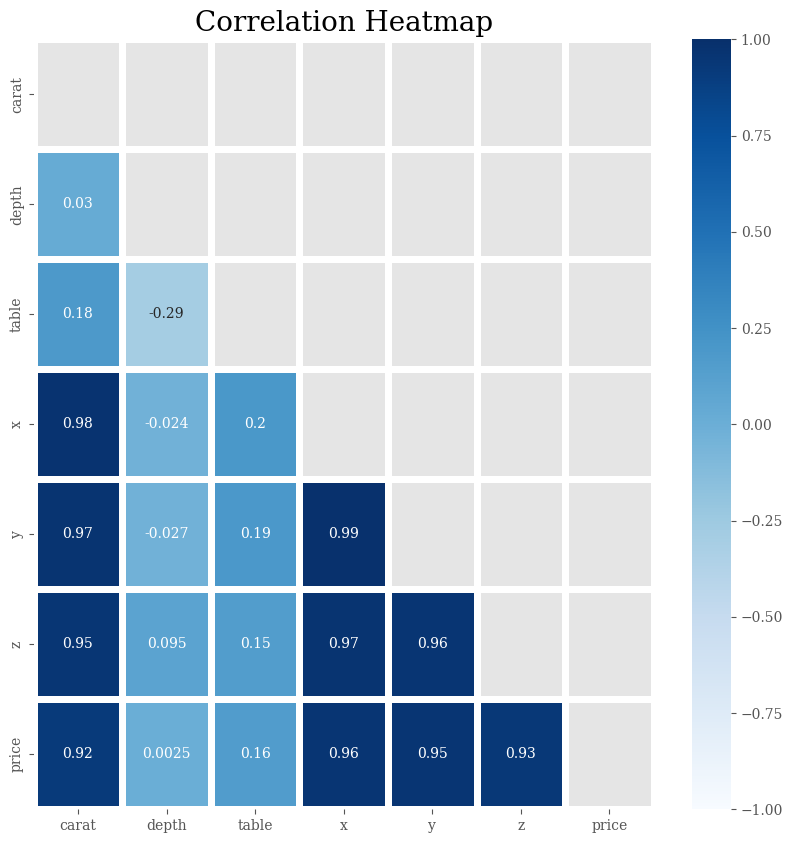

In [301]:
corr = df[num_cols].corr()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize = (10,10))
sns.heatmap(corr, mask = mask, cmap = 'Blues', linewidths = 5,
            annot = True, vmin = -1, vmax = 1)
plt.title('Correlation Heatmap', fontsize = 20)

Text(0.5, 1.1, 'Regplot of Numeric value')

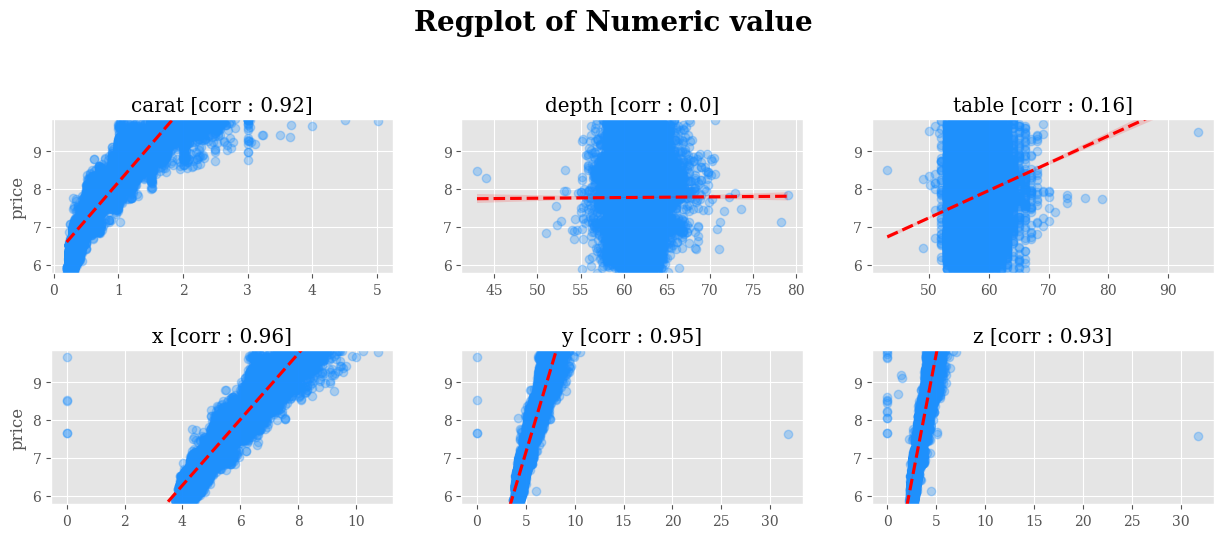

In [302]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize  = (15,5))

ax = ax.flatten()

fig.subplots_adjust(hspace = 0.5)

for i,col in enumerate(num_cols[:-1]): # drop price
    
    corr = round(df[['price',col]].corr().iloc[0,1],2)
    
    sns.regplot(data = df,
                x = col,
                y = 'price',
                ax = ax[i],
                scatter_kws = {'alpha': 0.3, 'color' : 'dodgerblue'},
                line_kws = {'color': 'red' , 'linestyle' : '--'})
    
    ax[i].set_xlabel('')
    
    if i % 3 != 0 :
        ax[i].set_ylabel('')
    ax[i].set_title(f'{col} [corr : {corr}]')
    
    ax[i].set_ylim([min(df['price']), max(df['price'])])
    
    
fig.suptitle('Regplot of Numeric value', fontsize = 20,weight = 'bold', y = 1.1)

# Object Value EDA 

Text(0.5, 0.98, 'Histplot of Objective value')

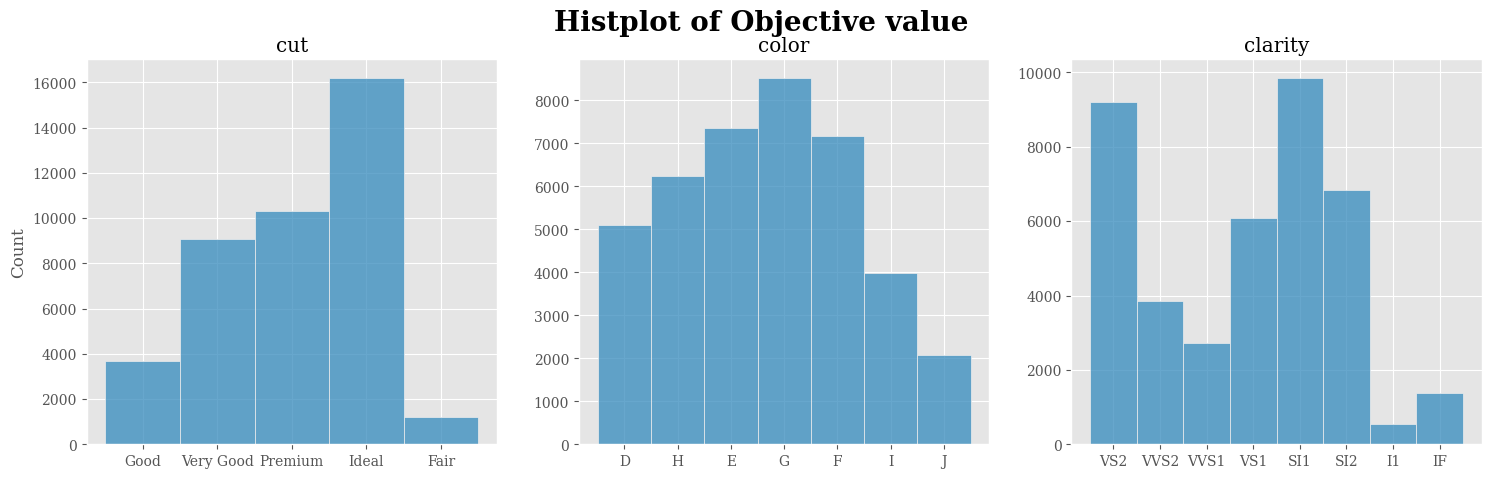

In [303]:
fig,ax = plt.subplots(ncols = 3, figsize = (18,5))

for i,col in enumerate(obj_cols):
    
    sns.histplot(data = df,
                x = col,
                ax = ax[i])
    
    ax[i].set_title(col)
    
    if i != 0:
        ax[i].set_ylabel('')
        
    ax[i].set_xlabel('')
    
fig.suptitle('Histplot of Objective value', fontsize = 20, weight = 'bold')

Text(0.5, 0.98, 'Boxplot of Objective value')

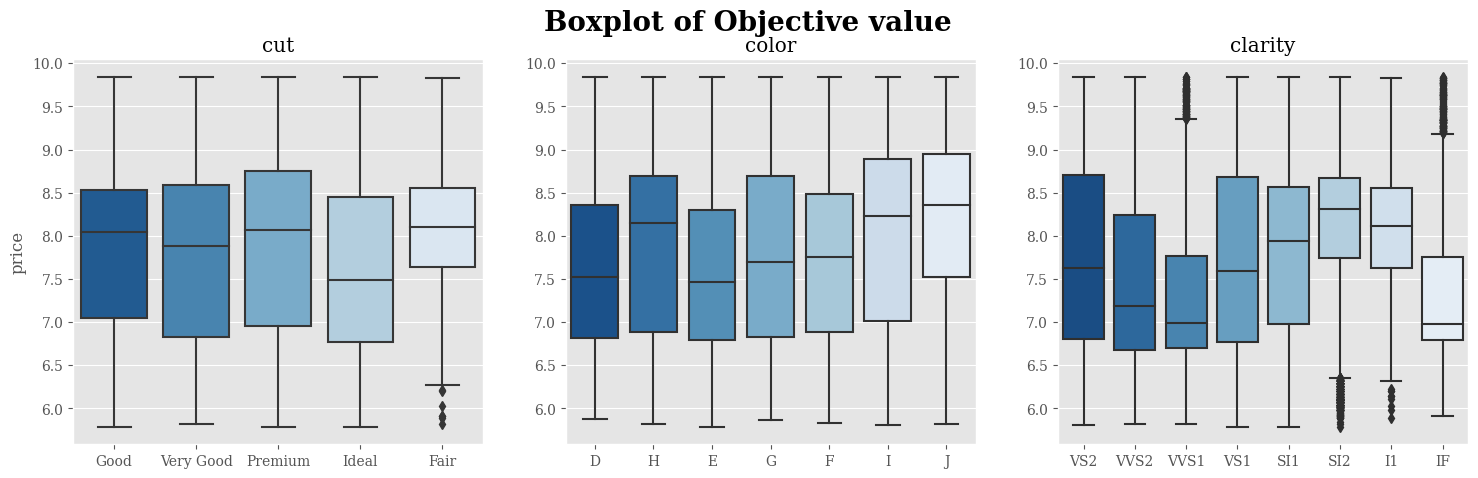

In [304]:
fig,ax = plt.subplots(ncols = 3, figsize = (18,5))

for i,col in enumerate(obj_cols):
    
    sns.boxplot(data = df,
                x = col,
                y = 'price',
                palette = 'Blues_r',
                ax = ax[i])
    
    ax[i].set_title(col)
    
    if i != 0:
        ax[i].set_ylabel('')
        
    ax[i].set_xlabel('')
    
fig.suptitle('Boxplot of Objective value',fontsize = 20,weight = 'bold')

# Modeling 

In [305]:
X = pd.get_dummies(df.drop('price',axis = 1))
y = df['price']

In [306]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [307]:
models = [RandomForestRegressor(), ExtraTreesRegressor(), XGBRegressor(), LGBMRegressor(verbosity = -1),
        CatBoostRegressor(verbose = 0), MLPRegressor(), Ridge(), Lasso()]

models_name = ['RandomForestRegressor', 'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor', 
                'CatBoostRegressor','MLPRegressor','Ridge','Lasso']

In [308]:
params = [
    {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 5
    },
    {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 5
    },
    {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 7
    },
    {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 7
    },
    {
        'iterations': 100,
        'learning_rate': 0.1,
        'depth': 7
    },
    {
        'hidden_layer_sizes': (50,),
        'activation': 'relu',
        'alpha': 0.01
    },
    {
        'alpha': 0.1,
        'solver': 'auto'
    },
    {
        'alpha': 0.1,
        'selection': 'cyclic'
    }
]

In [309]:
models_with_params = []

for param,model in zip(params,models):
    
    model.set_params(**param)
    models_with_params.append(model)

# OOF Ensemble

In [312]:
%%time

splits = 5

cv = KFold(n_splits = splits, shuffle = True, random_state =42)


for i,model in enumerate(models_with_params):
    
    print('--' * 20)
    
    name = models_name[i]

    valid_avg_score = 0        
    valid_avg_score = 0
    
    for num,(train_idx,test_idx) in enumerate(cv.split(x_train,y_train)):
        
        train_x,train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x,valid_y = x_train.iloc[test_idx], y_train.iloc[test_idx]
        
        model.fit(train_x,train_y)
        
        pred = model.predict(valid_x)
        oof_pred = model.predict(x_test)
        
        valid_score = round(mean_squared_error(valid_y,pred),3)
        oof_score = round(mean_squared_error(y_test,oof_pred),3)
                
        print(f'{blu}{name} {num} FOLD MSE : {red}{valid_score}')
        
        valid_avg_score += valid_score / splits
        valid_avg_score += oof_score / splits
        
    print(f'{blu}{name} 5 FOLD AVG MSE : {red}{valid_avg_score}')
    print(f'{blu}{name} 5 FOLD OOF AVG MSE : {red}{valid_avg_score}')

----------------------------------------
RandomForestRegressor 0 FOLD MSE : 0.009
RandomForestRegressor 1 FOLD MSE : 0.009
RandomForestRegressor 2 FOLD MSE : 0.009
RandomForestRegressor 3 FOLD MSE : 0.009
RandomForestRegressor 4 FOLD MSE : 0.01
RandomForestRegressor 5 FOLD AVG MSE : 0.0184
RandomForestRegressor 5 FOLD OOF AVG MSE : 0.0184
----------------------------------------
ExtraTreesRegressor 0 FOLD MSE : 0.009
ExtraTreesRegressor 1 FOLD MSE : 0.009
ExtraTreesRegressor 2 FOLD MSE : 0.009
ExtraTreesRegressor 3 FOLD MSE : 0.009
ExtraTreesRegressor 4 FOLD MSE : 0.01
ExtraTreesRegressor 5 FOLD AVG MSE : 0.018199999999999997
ExtraTreesRegressor 5 FOLD OOF AVG MSE : 0.018199999999999997
----------------------------------------
XGBRegressor 0 FOLD MSE : 0.009
XGBRegressor 1 FOLD MSE : 0.008
XGBRegressor 2 FOLD MSE : 0.009
XGBRegressor 3 FOLD MSE : 0.009
XGBRegressor 4 FOLD MSE : 0.01
XGBRegressor 5 FOLD AVG MSE : 0.018
XGBRegressor 5 FOLD OOF AVG MSE : 0.018
----------------------------

# OOF Ensemble Submission

In [315]:
test = pd.get_dummies(test)

In [320]:
%% times

splits = 5
num_models = len(models_with_params)

oof_pred = [np.zeros(len(test)) for _ in range(num_models)]

cv = KFold(n_splits = splits, shuffle = True, random_state =42)

for i,model in enumerate(models_with_params):
    
    for num,(train_idx,test_idx) in enumerate(cv.split(X,y)):
        
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = model.predict(test)
        
        oof_pred[i] += pred / splits

In [323]:
oof_result = np.mean(oof_pred,axis = 0)
oof_result

array([8.08890278, 6.69304482, 6.78298741, ..., 9.21334158, 7.0590184 ,
       9.71618692])

In [325]:
sub = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/sample_submission.csv')
sub['price'] = oof_result

In [328]:
sub.to_csv('oof_ensemble.csv', index = False)

# Stacking

In [339]:
base_model = [(models_name[i], model) for i, model in enumerate(models_with_params)]

stacking = StackingRegressor(estimators = base_model,
                    final_estimator = LADRegression())

In [344]:
stacking.fit(x_train,y_train)

valid_pred = stacking.predict(x_test)
valid_score = round(mean_squared_error(y_test,valid_pred), 3)

print(f'Stacking Validation MSE : {valid_score}')

Stacking Validation MSE : 0.008


In [345]:
stacking_pred = stacking.predict(test)

In [347]:
sub['price'] = stacking_pred

sub.to_csv('Stacking.csv',index = False)